## Match LODES Joblist Data to IN-CORE School Building Data

The Longitudinal Employer-Household Dynamics (LEHD) Origin-Destination Employment Statistics (LODES) provides details on jobs across the United States. The publicly accessible data has been modified to provide a list of jobs with characteristics (Race, Ethnicity, Age, Sex, Education, Earnings, Industry, and Jobtype). This joblist includes the latitude and longitude for both the work block and the estimated home block. **NOTE** This data is coaresended and fuzzed and can not be used to identify individuals.

U.S. Census Bureau. (2021). LEHD Origin-Destination Employment Statistics Data (2002-2018) [computer file]. Washington, DC: U.S. Census Bureau, Longitudinal-Employer Household Dynamics Program [distributor], accessed on {2021-08-18} at https://lehd.ces.census.gov/data/#lodes. LODES 7.5 [version]

This data can be matched to the nearest IN-CORE buildings identified as school buildings.

Based on help from:

https://osmnx.readthedocs.io/en/stable/osmnx.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html

Goal is to accurately assign job (labor) information to work buildings.


## Description of Program
- program:    IN-CORE_2cv1_MatchLodesSchoolBuilding
- task:       Match LODES joblist point data to nearest building location
- Version:    2021-08-18
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE) Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, N. (2021) “Obtain, Clean, and Explore Labor Market Allocation Methods". 
Archived on Github and ICPSR.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np  # group by aggregation
import folium as fm # folium has more dynamic maps - but requires internet connection

In [2]:
# Display versions being used - important information for replication
import os
import sys
print("Python Version     ", sys.version)
print("geopandas version: ", gpd.__version__)
print("pandas version:    ", pd.__version__)
print("numpy version:     ", np.__version__)
print("folium version:    ", fm.__version__)

Python Version      3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
geopandas version:  0.9.0
pandas version:     1.3.1
numpy version:      1.21.1
folium version:     unknown


In [3]:
import os # For saving output to path
# Store Program Name for output files to have the same name
programname = "IN-CORE_2cv1_MatchLodesSchoolBuilding_2021-08-19"

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - this helps to follow the overall workflow
outputfolder = "workflow_output"
# Make directory to save output
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Setup notebook enviroment to access Cloned Github Package
This notebook uses packages that are in developement. The packages are available at:

https://github.com/npr99/Labor_Market_Allocation

To replicate this notebook Clone the Github Package to a folder that is a sibling of this notebook.

To access the sibling package you will need to append the parent directory ('..') to the system path list.

In [4]:
# Current System Path List
sys.path

['G:\\Shared drives\\HRRC_IN-CORE\\Tasks\\P4.9 Testebeds\\Lumberton_LaborMarketAllocation\\github_com\\npr99\\Labor_Market_Allocation\\pyincoredata_addons\\WorkNPR',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\python37.zip',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\DLLs',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802',
 '',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\win32',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\nathanael99\\.ipython']

In [5]:
# append the path of the
# parent directory
sys.path.append("..")
sys.path

['G:\\Shared drives\\HRRC_IN-CORE\\Tasks\\P4.9 Testebeds\\Lumberton_LaborMarketAllocation\\github_com\\npr99\\Labor_Market_Allocation\\pyincoredata_addons\\WorkNPR',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\python37.zip',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\DLLs',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802',
 '',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\win32',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\nathanael99\\Miniconda3\\envs\\pyincoreEnv20210802\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\nathanael99\\.ipython',
 '..']

# Setup access to IN-CORE
https://incore.ncsa.illinois.edu/

In [6]:
from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore_viz.geoutil import GeoUtil as viz

In [7]:
#client = IncoreClient()
# IN-CORE chaches files on the local machine, it might be necessary to clear the memory
#client.clear_cache()

In [8]:
# create data_service object for loading files
#data_service = DataService(client)

### IN-CORE addons
This program uses coded that is being developed as potential add ons to pyincore. These functions are in a folder called pyincore_addons - this folder is located in the same directory as this notebook.
The add on functions are organized to mirror the folder sturcture of https://github.com/IN-CORE/pyincore

Each add on function attempts to follow the structure of existing pyincore functions and includes some help information.

In [9]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2

# open, read, and execute python program with reusable commands
from pyincore_addons.geoutil_20210618 import df2gdf_WKTgeometry
from pyincore_addons.geoutil_20210618 import nearest_pt_search

## Read in Building Data


In [10]:
sourceprogram = "IN-CORE_2bv1_MatchNCESSchoolBuilding_2021-08-19"
filename = outputfolder+"/"+sourceprogram+".csv"
building_df = pd.read_csv(filename)

# Convert dataframe to gdf
building_gdf = df2gdf_WKTgeometry(df = building_df, projection = "epsg:26917",reproject="epsg:26917", geometryvar = 'geometry_x')
building_gdf.head(2)

,Unnamed: 0,guid,geometry_x,LON_x,LAT_x,neighbor,distance,distoutlier,location a index,index,ncesid,geometry_y,LON_y,LAT_y,geometry
0,0,66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a,POINT (672189.4653744148 3829164.868139791),672189.465374,3.829165e+06,1,176.397646,False,20.0,20,370393002049,POINT (672082.102054823 3829304.829731766),672082.102055,3.829305e+06,POINT (672189.465 3829164.868)
1,1,31d34dad-4211-40d9-b4e3-38677b5ee72f,POINT (672181.9582940752 3829181.790257033),672181.958294,3.829182e+06,1,158.461291,False,20.0,20,370393002049,POINT (672082.102054823 3829304.829731766),672082.102055,3.829305e+06,POINT (672181.958 3829181.790)


In [11]:
help(viz.plot_gdf_map)

Help on function plot_gdf_map in module pyincore_viz.geoutil:

plot_gdf_map(gdf, column, category=False, basemap=True, source={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': '(C) OpenStreetMap contributors', 'name': 'OpenStreetMap.Mapnik'})
    Plot Geopandas DataFrame.
    
    Args:
        gdf (obj): Geopandas DataFrame object.
        column (str): A column name to be plot.
        category (bool): Turn on/off category option.
        basemap (bool): Turn on/off base map (e.g. openstreetmap).
        source(obj): source of the Map to be used. examples, ctx.providers.OpenStreetMap.Mapnik (default),
            ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron etc.



Map of school buildings 10 = One Story [84], 11 = Two Story [4]


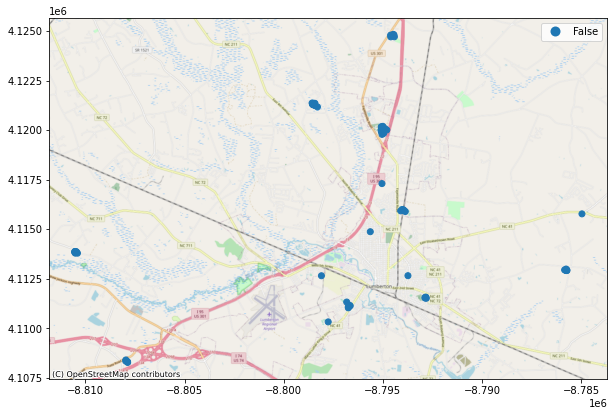

In [12]:
map = viz.plot_gdf_map(building_gdf,column='distoutlier', category=True)
print("Map of school buildings 10 = One Story [84], 11 = Two Story [4]")
map

In [13]:
building_gdf['guid'].describe()

count                                       78
unique                                      78
top       66b1392e-c7b0-4bd8-a092-a7ff0ea6c15a
freq                                         1
Name: guid, dtype: object

In [14]:
# Convert NCESID to string for merge
building_gdf.loc[:,'ncesid'] = building_gdf['ncesid'].astype(str)
building_gdf['ncesid'].describe()

count               78
unique              15
top       370393002791
freq                14
Name: ncesid, dtype: object

## Read in School Name Data

In [15]:
sourcefolder = '../SourceData/nces_ed_gov/'
sourceprogram = "NCES_2bv1_AddTeacherCount_2021-06-15"
filename = sourcefolder+"/"+sourceprogram+"/"+sourceprogram+".csv"
school_df = pd.read_csv(filename)

school_df = school_df.rename(columns = {'name' : 'school_name'})
school_df[['ncesid','school_name','numstaff']].head()

,ncesid,school_name,numstaff
0,370004002349,CIS Academy,7.99
1,370034603302,Southeastern Academy,15.00
2,370225003249,Sandy Grove Middle,36.25
3,370393001569,Deep Branch Elementary,23.84
4,370393001570,Fairgrove Middle,22.98


In [16]:
school_df['ncesid'].describe()

count               55
unique              55
top       370004002349
freq                 1
Name: ncesid, dtype: object

In [17]:
building_school_gdf = pd.merge(right = building_gdf,
                               left  = school_df[['ncesid','school_name','numstaff']],
                               on = 'ncesid')
building_school_gdf[['guid','ncesid','school_name']].astype(str).describe()

,guid,ncesid,school_name
count,78,78,78
unique,78,15,15
top,b7244375-deb9-4013-9fee-8769da7693f4,370393002791,PSRC Early College at RCC
freq,1,14,14


In [18]:
building_school_gdf.loc[building_school_gdf['school_name'].str.startswith('Rowland ')]

,ncesid,school_name,numstaff,Unnamed: 0,guid,geometry_x,LON_x,LAT_x,neighbor,distance,distoutlier,location a index,index,geometry_y,LON_y,LAT_y,geometry
55,370393002242,Rowland Norment Elementary,29.53,32,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,POINT (683766.0696250959 3832976.288860729),683766.069625,3.832976e+06,1,33.34628,False,37.0,37,POINT (683732.8042616628 3832973.967233401),683732.804262,3.832974e+06,POINT (683766.070 3832976.289)


## Read in LODES Joblist Data
The LODES Joblist data should match to Rowland Elementary

In [19]:
sourceprogram = "LODES_3av1_ExploreLODESdata_2021-08-18"
filename = "lodes_workflow_output"+"/"+sourceprogram+"_2015.csv"
joblist_df = pd.read_csv(filename)
joblist_df.head()

,Unnamed: 0,Unnamed: 0.1,w_geocode,h_geocode,jobidod,jobidod_counter,jobidod_total_rand,jobidwacracod_counter,jobidac,jobidac_counter,...,tabblk2010_w,blklatdd_w,blklondd_w,h_geocode_stfips,h_geocode_stabbr,tabblk2010_h,blklatdd_h,blklondd_h,od_distance,h_geocode_coarse
0,0,1,371559612002006,370179503001059,jidodJT07213,1,0,0,jidodJT07213jobidac211512,1,...,371559612002006,34.622429,-78.995762,37,nc,370179503001059,34.644261,-78.716620,25.654264,37017950300
1,1,2,371559612002006,370190203042017,jidodJT07223,1,0,7,jidodJT07223jobidac311532,1,...,371559612002006,34.622429,-78.995762,37,nc,370190203042017,33.953199,-78.086835,111.849522,37019
2,2,3,371559612002006,370479302001019,jidodJT07333,1,0,3,jidodJT07333jobidac411532,1,...,371559612002006,34.622429,-78.995762,37,nc,370479302001019,34.362963,-78.411764,60.802301,37047
3,3,4,371559612002006,370479306003057,jidodJT07323,1,0,0,jidodJT07323jobidac211512,1,...,371559612002006,34.622429,-78.995762,37,nc,370479306003057,34.284822,-78.899931,38.554777,37047930600
4,4,5,371559612002006,370510030013000,jidodJT07233,1,0,37,jidodJT07233jobidac411512,1,...,371559612002006,34.622429,-78.995762,37,nc,370510030013000,34.914973,-78.927020,33.129850,37051003001


In [20]:
# Convert CSV LAT LON to WKT and Geodataframe
joblist_df['geometry'] = joblist_df.apply(lambda x: 'POINT ( ' +
                                str(x['blklondd_w']) + ' ' +
                                str(x['blklatdd_w']) + ')', axis = 1)
joblist_df[['w_geocode','jobidac','geometry']].head()

,w_geocode,jobidac,geometry
0,371559612002006,jidodJT07213jobidac211512,POINT ( -78.9957616 34.6224293)
1,371559612002006,jidodJT07223jobidac311532,POINT ( -78.9957616 34.6224293)
2,371559612002006,jidodJT07333jobidac411532,POINT ( -78.9957616 34.6224293)
3,371559612002006,jidodJT07323jobidac211512,POINT ( -78.9957616 34.6224293)
4,371559612002006,jidodJT07233jobidac411512,POINT ( -78.9957616 34.6224293)


In [21]:
# Convert dataframe to gdf
joblist_gdf = df2gdf_WKTgeometry(df = joblist_df, projection = "epsg:4326",reproject="epsg:26917", geometryvar = 'geometry')
joblist_gdf.head(2)

,Unnamed: 0,Unnamed: 0.1,w_geocode,h_geocode,jobidod,jobidod_counter,jobidod_total_rand,jobidwacracod_counter,jobidac,jobidac_counter,...,blklatdd_w,blklondd_w,h_geocode_stfips,h_geocode_stabbr,tabblk2010_h,blklatdd_h,blklondd_h,od_distance,h_geocode_coarse,geometry
0,0,1,371559612002006,370179503001059,jidodJT07213,1,0,0,jidodJT07213jobidac211512,1,...,34.622429,-78.995762,37,nc,370179503001059,34.644261,-78.716620,25.654264,37017950300,POINT (683739.354 3832999.877)
1,1,2,371559612002006,370190203042017,jidodJT07223,1,0,7,jidodJT07223jobidac311532,1,...,34.622429,-78.995762,37,nc,370190203042017,33.953199,-78.086835,111.849522,37019,POINT (683739.354 3832999.877)


Map of Jobs in Joblist


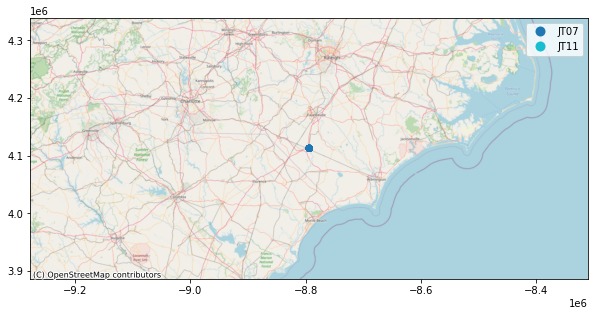

In [22]:
map = viz.plot_gdf_map(joblist_gdf,column='jobtype', category=True)
print("Map of Jobs in Joblist")
map

In [23]:
joblist_gdf[['w_geocode','h_geocode','jobidac','jobidod_counter','geometry']].astype(str).describe()

,w_geocode,h_geocode,jobidac,jobidod_counter,geometry
count,74,74,74,74,74
unique,1,72,54,1,1
top,371559612002006,371559615003025,jidodJT07233jobidac311512,1,POINT (683739.3540604457 3832999.876577704)
freq,74,2,4,74,74


### Add Unique ID to joblist
Dataframe requires a unique id for the nearest neighbor search

In [24]:
joblist_gdf['uniquejobid'] =  joblist_gdf.apply(lambda x: 'ID' +
                                str(x['w_geocode']) +
                                str(x['h_geocode']) +
                                str(x['jobidac']) + 
                                str(x['jobidod_counter']) 
                                              , axis = 1)
joblist_gdf['uniquejobid'].describe()

count                                                    74
unique                                                   74
top       ID371559612002006370179503001059jidodJT07213jo...
freq                                                      1
Name: uniquejobid, dtype: object

## Set up data for nearest neighbor search

We want to add the nearest GUID to the joblist

## Run nearest neighbor algorithm

In [25]:
help(nearest_pt_search)

Help on function nearest_pt_search in module pyincore_addons.geoutil_20210618:

nearest_pt_search(gdf_a: geopandas.geodataframe.GeoDataFrame, gdf_b: geopandas.geodataframe.GeoDataFrame, uniqueid_a: str, uniqueid_b: str, k=1, dist_cutoff=99999)
    Given two sets of points add unique id from locations a to locations b
    Inspired by: https://towardsdatascience.com/using-scikit-learns-binary-trees-to-efficiently-find-latitude-and-longitude-neighbors-909979bd929b
    
    This function is used to itdentify buildings associated with businesses, schools, hospitals.
    The locations of businesses might be geocoded by address and may not overlap
    the actual structure. This function helps resolve this issue.
    
    Tested Python Enviroment:
        Python Version      3.7.10
        geopandas version:  0.9.0
        pandas version:     1.2.4
        scipy version:     1.6.3
        numpy version:      1.20.2
    
    Args:
        gdf_a: Geodataframe with list of locations with unique i

In [26]:
job_building_gdf = nearest_pt_search(gdf_a = building_gdf,
                                               gdf_b = joblist_gdf,
                                               uniqueid_a = 'guid',
                                               uniqueid_b = 'uniquejobid',
                                               k = 6,
                                               dist_cutoff = 250)

In [27]:
job_building_gdf.head()

,uniquejobid,geometry_x,LON_x,LAT_x,neighbor,distance,distoutlier,location a index,index,guid,geometry_y,LON_y,LAT_y
0,ID371559612002006370179503001059jidodJT07213jo...,POINT (683739.354 3832999.877),683739.35406,3.833000e+06,1,35.638487,False,26.0,26,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,POINT (683766.070 3832976.289),683766.069625,3.832976e+06
1,ID371559612002006370190203042017jidodJT07223jo...,POINT (683739.354 3832999.877),683739.35406,3.833000e+06,1,35.638487,False,26.0,26,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,POINT (683766.070 3832976.289),683766.069625,3.832976e+06
2,ID371559612002006370479302001019jidodJT07333jo...,POINT (683739.354 3832999.877),683739.35406,3.833000e+06,1,35.638487,False,26.0,26,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,POINT (683766.070 3832976.289),683766.069625,3.832976e+06
3,ID371559612002006370479306003057jidodJT07323jo...,POINT (683739.354 3832999.877),683739.35406,3.833000e+06,1,35.638487,False,26.0,26,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,POINT (683766.070 3832976.289),683766.069625,3.832976e+06
4,ID371559612002006370510030013000jidodJT07233jo...,POINT (683739.354 3832999.877),683739.35406,3.833000e+06,1,35.638487,False,26.0,26,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,POINT (683766.070 3832976.289),683766.069625,3.832976e+06


In [28]:
job_building_gdf[['neighbor','guid']].fillna('none').groupby(
    ['neighbor']).count()

,guid
neighbor,
1,74


In [29]:
job_building_gdf.guid.describe()

count                                       74
unique                                       1
top       f8c00a5d-f1ed-400b-b4dc-398c76119a9b
freq                                        74
Name: guid, dtype: object

## Add GUID and Building Point Geometry to Joblist

In [30]:
joblist_guid_gdf = pd.merge(right = joblist_gdf,
                               left  = job_building_gdf[['uniquejobid','guid','geometry_y','LON_y','LAT_y']],
                               on = 'uniquejobid')
joblist_guid_gdf[['uniquejobid','guid']].astype(str).describe()

,uniquejobid,guid
count,74,74
unique,74,1
top,ID371559612002006370179503001059jidodJT07213jo...,f8c00a5d-f1ed-400b-b4dc-398c76119a9b
freq,1,74


In [31]:
joblist_guid_ncesid_gdf = pd.merge(right = joblist_guid_gdf,
                               left  = building_school_gdf[['guid','ncesid','school_name']],
                               on = 'guid')
joblist_guid_ncesid_gdf[['uniquejobid','guid','ncesid','school_name']].astype(str).describe()

,uniquejobid,guid,ncesid,school_name
count,74,74,74,74
unique,74,1,1,1
top,ID371559612002006370179503001059jidodJT07213jo...,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,370393002242,Rowland Norment Elementary
freq,1,74,74,74


## Check Joblist with School Building

In [32]:
joblist_guid_ncesid_gdf[['guid','ncesid','school_name','Earnings','Race','Ethnicity','Sex','h_geocode']].head()

,guid,ncesid,school_name,Earnings,Race,Ethnicity,Sex,h_geocode
0,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,370393002242,Rowland Norment Elementary,1,1,1,2,370179503001059
1,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,370393002242,Rowland Norment Elementary,2,3,1,2,370190203042017
2,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,370393002242,Rowland Norment Elementary,3,3,1,2,370479302001019
3,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,370393002242,Rowland Norment Elementary,2,1,1,2,370479306003057
4,f8c00a5d-f1ed-400b-b4dc-398c76119a9b,370393002242,Rowland Norment Elementary,3,1,1,2,370510030013000


In [33]:
# Save Work at this point as CSV
savefile = sys.path[0]+"/"+outputfolder+"/"+programname+".csv"
joblist_guid_ncesid_gdf.to_csv(savefile)